In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import folium
import re

In [3]:
plt.rcParams["figure.dpi"] = 140
sns.set_theme(context="notebook", style="whitegrid")

In [5]:
INPUT_PATH = Path("/kaggle/input/bike-dataset/metro-bike-share-trip-data.csv")
OUTPUT_DIR = Path("/kaggle/working")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [10]:
colmap = {
    "Trip ID": "trip_id",
    "Duration": "duration",
    "Start Time": "start_time",
    "End Time": "end_time",
    "Starting Station ID": "start_station_id",
    "Starting Station Latitude": "start_lat",
    "Starting Station Longitude": "start_lon",
    "Ending Station ID": "end_station_id",
    "Ending Station Latitude": "end_lat",
    "Ending Station Longitude": "end_lon",
}

# Common variants just in case your CSV uses slightly different labels
variants = {
    "Trip ID": ["trip id", "trip_id", "tripid"],
    "Duration": ["duration", "trip duration", "tripduration", "duration (sec)", "duration (min)"],
    "Start Time": ["start time", "start_time", "starttime", "start datetime"],
    "End Time": ["end time", "end_time", "endtime", "end datetime"],
    "Starting Station ID": ["starting station id", "start station id", "from station id"],
    "Starting Station Latitude": ["starting station latitude", "start station latitude", "from station latitude", "start lat"],
    "Starting Station Longitude": ["starting station longitude", "start station longitude", "from station longitude", "start lon", "start long"],
    "Ending Station ID": ["ending station id", "end station id", "to station id"],
    "Ending Station Latitude": ["ending station latitude", "end station latitude", "to station latitude", "end lat"],
    "Ending Station Longitude": ["ending station longitude", "end station longitude", "to station longitude", "end lon", "end long"],
}

def norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", " ", s.lower()).strip()

raw_cols = list(raw.columns)
raw_norm_to_orig = {norm(c): c for c in raw_cols}

resolved = {}  # original_name -> new_name

for nice, newname in colmap.items():
    candidates = [nice] + variants.get(nice, [])
    matched = None
    for cand in candidates:
        key = norm(cand)
        if key in raw_norm_to_orig:
            matched = raw_norm_to_orig[key]
            break
    if matched:
        resolved[matched] = newname
    else:
        print(f"[WARN] Could not find column for '{nice}'. Looked for variants: {candidates}")

# Apply rename
df = raw.rename(columns=resolved).copy()

# 2) Verify we got everything we need
expected = set(colmap.values())
have = set(df.columns) & expected
missing = sorted(expected - have)
print("Mapped columns:", {k: v for k, v in resolved.items()})
print("Missing after rename:", missing)

if missing:
    # Helpful: show your original columns to spot typos
    print("\nAvailable columns in your file:")
    for c in raw_cols:
        print(" -", c)
    raise ValueError("Some required columns are missing. See warnings above.")

Mapped columns: {'Trip ID': 'trip_id', 'Duration': 'duration', 'Start Time': 'start_time', 'End Time': 'end_time', 'Starting Station ID': 'start_station_id', 'Starting Station Latitude': 'start_lat', 'Starting Station Longitude': 'start_lon', 'Ending Station ID': 'end_station_id', 'Ending Station Latitude': 'end_lat', 'Ending Station Longitude': 'end_lon'}
Missing after rename: []


In [11]:

# Parse timestamps
df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
df["end_time"]   = pd.to_datetime(df["end_time"], errors="coerce")
df = df.dropna(subset=["start_time","end_time"])


In [12]:
# Detect duration unit (seconds vs minutes)
dur = pd.to_numeric(df["duration"], errors="coerce")
seconds_like = dur.median() > 300  # >5 minutes median => very likely seconds
df["duration_min"] = dur / 60.0 if seconds_like else dur

In [13]:
# Cross-check duration from timestamps (not all datasets align perfectly)
df["duration_min_from_time"] = (df["end_time"] - df["start_time"]).dt.total_seconds() / 60
print("Median |provided - computed| duration (min):",
      (df["duration_min"] - df["duration_min_from_time"]).abs().median())

Median |provided - computed| duration (min): 0.0


In [15]:
# Coordinate sanity + LA bounding box
df = df.dropna(subset=["start_lat","start_lon","end_lat","end_lon"])
df = df[df["start_lat"].between(33.5, 34.5) & df["start_lon"].between(-119, -117)]
df = df[df["end_lat"].between(33.5, 34.5) & df["end_lon"].between(-119, -117)]

In [16]:
# Duration sanity
df = df[(df["duration_min"] >= 1) & (df["duration_min"] <= 24*60)].copy()

In [17]:
print("Rows after cleaning:", len(df))
df.head()

Rows after cleaning: 131276


,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long,duration_min,duration_min_from_time
0,1912818,180,2016-07-07 04:17:00,2016-07-07 04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",3.0,3.0
1,1919661,1980,2016-07-07 06:00:00,2016-07-07 06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",33.0,33.0
2,1933383,300,2016-07-07 10:32:00,2016-07-07 10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05...",5.0,5.0
3,1944197,10860,2016-07-07 10:37:00,2016-07-07 13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05...",181.0,181.0
4,1940317,420,2016-07-07 12:51:00,2016-07-07 12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04...",7.0,7.0


In [18]:
# Time features
df["date"]  = df["start_time"].dt.date
df["year"]  = df["start_time"].dt.year
df["month"] = df["start_time"].dt.month
df["dow"]   = df["start_time"].dt.day_name()
df["hour"]  = df["start_time"].dt.hour
df["week"]  = df["start_time"].dt.isocalendar().week.astype(int)
df["is_weekend"] = df["dow"].isin(["Saturday","Sunday"]).astype(int)

In [19]:
# Haversine distance (km) start -> end, and speed
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1, p2 = np.radians(lat1), np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df["trip_km"]  = haversine(df["start_lat"], df["start_lon"], df["end_lat"], df["end_lon"])
df["km_per_hr"] = df["trip_km"] / (df["duration_min"] / 60)

In [20]:
# Filter obviously impossible speeds
df = df[(df["trip_km"] >= 0) & (df["km_per_hr"] <= 35)].copy()

n_days = df["date"].nunique()
print("Distinct days in this file:", n_days)
df[["duration_min","trip_km","km_per_hr"]].describe()

Distinct days in this file: 268


,duration_min,trip_km,km_per_hr
count,131267.000000,131267.000000,131267.000000
mean,22.592373,1.066052,6.379572
std,78.043829,0.721987,3.798982
min,1.000000,0.000000,0.000000
25%,6.000000,0.578459,3.785943
50%,10.000000,0.960393,6.804293
75%,18.000000,1.455234,8.932333
max,1440.000000,22.641074,34.889363


In [21]:
#Build Station Catalog

In [22]:
starts = df[["start_station_id","start_lat","start_lon"]].rename(
    columns={"start_station_id":"station_id","start_lat":"lat","start_lon":"lon"}
)
ends = df[["end_station_id","end_lat","end_lon"]].rename(
    columns={"end_station_id":"station_id","end_lat":"lat","end_lon":"lon"}
)
stations = pd.concat([starts, ends], ignore_index=True).dropna()
stations = stations.groupby("station_id").agg(lat=("lat","median"), lon=("lon","median")).reset_index()
stations.head()

,station_id,lat,lon
0,3005.0,34.048550,-118.259048
1,3006.0,34.045540,-118.256668
2,3007.0,34.050480,-118.254593
3,3008.0,34.046612,-118.262733
4,3009.0,33.987381,-118.472832


In [23]:
#When Does Demand Spike

In [24]:
sns.set_theme(context="notebook", style="whitegrid")

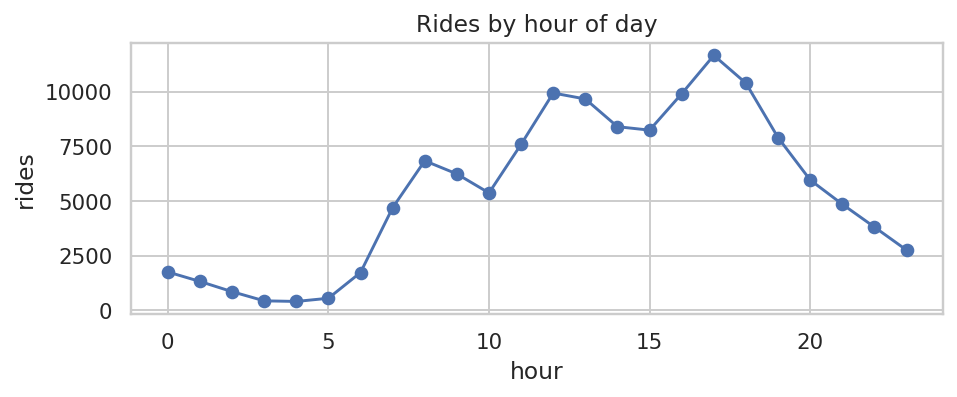

In [25]:
# Hour of day
hod = df.groupby("hour").size().rename("rides")
plt.figure(figsize=(7,3))
hod.plot(marker="o")
plt.title("Rides by hour of day")
plt.xlabel("hour"); plt.ylabel("rides")
plt.tight_layout(); plt.show()


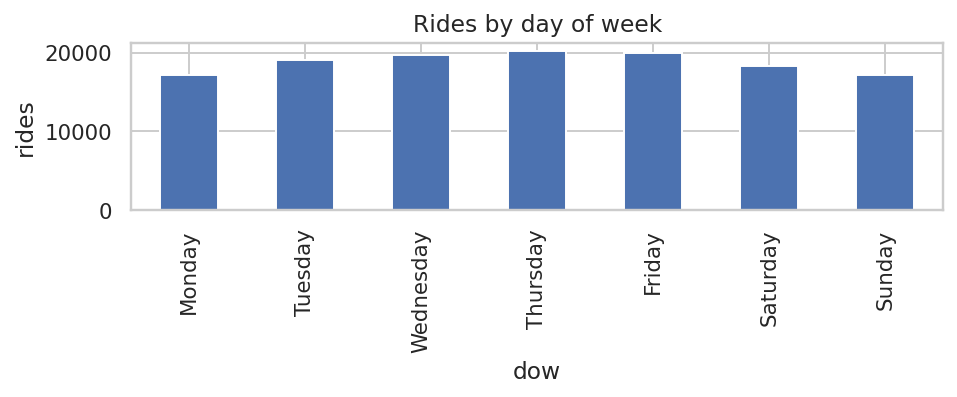

In [26]:
# Day of week (only if more than one day)
if n_days > 1:
    dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    dow = df.groupby("dow").size().reindex(dow_order)
    plt.figure(figsize=(7,3))
    dow.plot(kind="bar")
    plt.title("Rides by day of week")
    plt.ylabel("rides")
    plt.tight_layout(); plt.show()


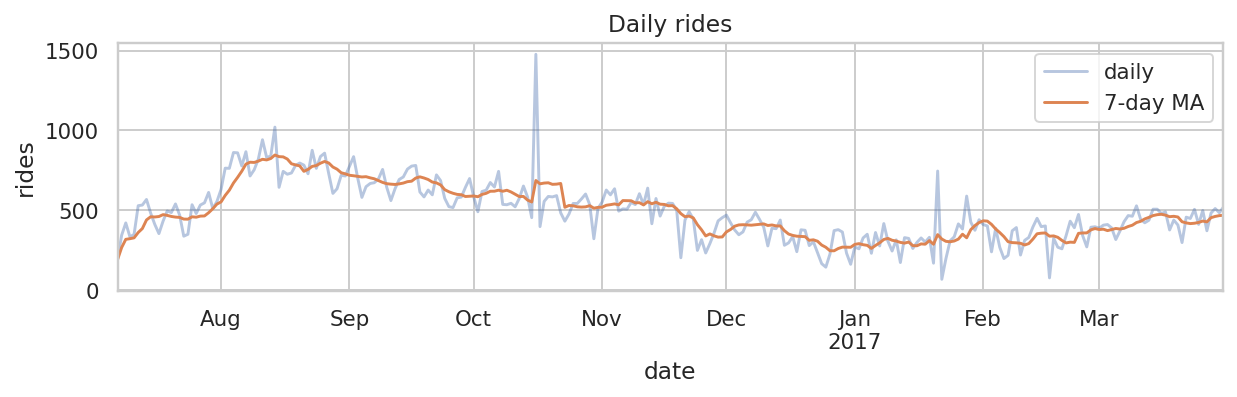

In [27]:
# Daily series (7-day MA only if >= 8 days)
if n_days >= 8:
    daily = df.groupby(pd.to_datetime(df["start_time"].dt.date)).size().rename("rides").to_frame()
    daily.index.name = "date"
    daily["rides_ma7"] = daily["rides"].rolling(7, min_periods=1).mean()

    fig, ax = plt.subplots(figsize=(9,3))
    daily["rides"].plot(ax=ax, alpha=0.4, label="daily")
    daily["rides_ma7"].plot(ax=ax, label="7-day MA")
    ax.set_title("Daily rides")
    ax.set_ylabel("rides"); ax.legend()
    plt.tight_layout(); plt.show()

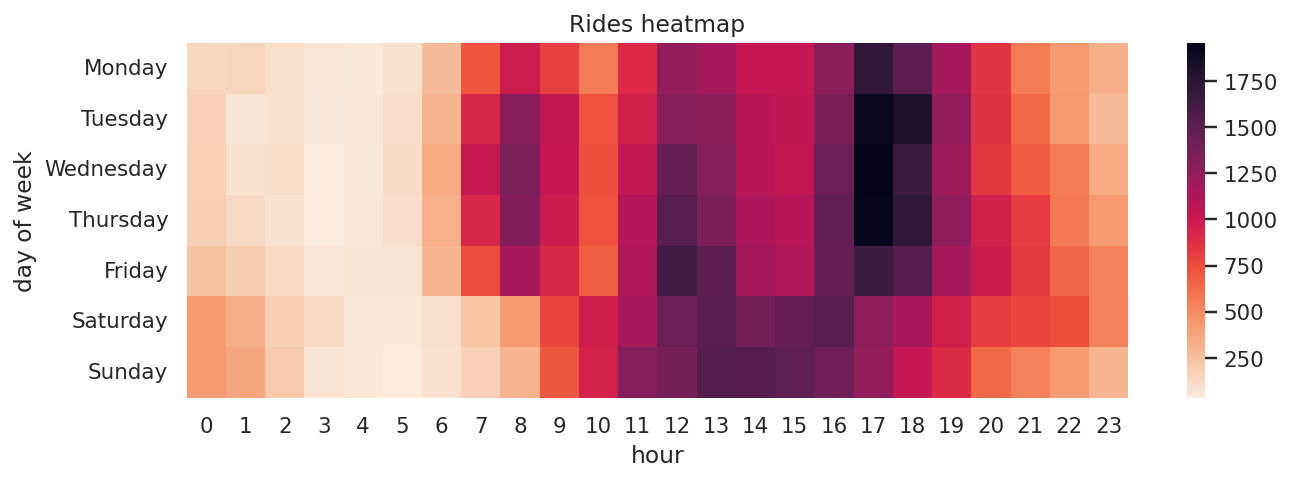

In [28]:
# Hour x Day heatmap
if n_days > 1:
    dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    heat = df.pivot_table(index="dow", columns="hour", values="trip_id", aggfunc="count").reindex(dow_order).fillna(0)
    y_label = "day of week"
else:
    only_day = str(pd.to_datetime(list(df["date"])[0]))
    heat = df.pivot_table(index=pd.Index([only_day]*len(df), name="date"),
                          columns="hour", values="trip_id", aggfunc="count").fillna(0)
    y_label = "date"

plt.figure(figsize=(10,3.6))
sns.heatmap(heat, cmap="rocket_r")
plt.title("Rides heatmap")
plt.xlabel("hour"); plt.ylabel(y_label)
plt.tight_layout(); plt.show()

In [29]:
#Where does demand spike

In [30]:
# Top origin stations
top_starts = df.groupby(["start_station_id"]).agg(
    rides=("trip_id","count"),
    lat=("start_lat","median"),
    lon=("start_lon","median"),
    median_trip_km=("trip_km","median"),
    median_duration_min=("duration_min","median")
).reset_index().sort_values("rides", ascending=False)
top_starts.head(15)

,start_station_id,rides,lat,lon,median_trip_km,median_duration_min
55,3069.0,5091,34.050880,-118.248253,0.976554,11.0
21,3030.0,5037,34.051941,-118.243530,0.814944,9.0
0,3005.0,4850,34.048550,-118.259048,0.843832,9.0
50,3064.0,4614,34.046810,-118.256981,0.791629,8.0
22,3031.0,4594,34.044701,-118.252441,0.788005,8.0
7,3014.0,4547,34.056610,-118.237213,1.176265,11.0
32,3042.0,3980,34.049301,-118.238808,0.904282,11.0
64,3082.0,3859,34.046520,-118.237411,1.210293,13.0
13,3022.0,3858,34.046070,-118.233093,1.264061,11.0
53,3067.0,3775,34.045181,-118.250237,0.896849,9.0


In [31]:
center = [stations["lat"].median(), stations["lon"].median()] if not stations.empty else [34.05, -118.25]
m = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")

for _, r in top_starts.head(150).iterrows():
    folium.CircleMarker(
        location=[r.lat, r.lon],
        radius=max(3, int(np.sqrt(r.rides)/2)),
        popup=f"Station {int(r.start_station_id)} — {int(r.rides):,} rides\n"
              f"Median {r.median_trip_km:.2f} km · {r.median_duration_min:.0f} min",
        fill=True
    ).add_to(m)

map_path = Path("/kaggle/working/station_hotspots.html")
m.save(str(map_path))
map_path

PosixPath('/kaggle/working/station_hotspots.html')

In [32]:
# Top flows (origin -> destination)
flows = df.groupby(["start_station_id","end_station_id"]).size().rename("rides").reset_index()
flows = flows.sort_values("rides", ascending=False)
flows.head(12)

,start_station_id,end_station_id,rides
1149,3030.0,3014.0,933
372,3014.0,3030.0,676
1204,3031.0,3005.0,609
1997,3048.0,3048.0,569
22,3005.0,3031.0,513
1173,3030.0,3042.0,506
707,3022.0,3022.0,450
3059,3069.0,3069.0,440
3554,3082.0,3082.0,391
25,3005.0,3034.0,389


In [33]:
# Flow map (top N pairs)
if not stations.empty:
    st_lat = stations.set_index("station_id")["lat"].to_dict()
    st_lon = stations.set_index("station_id")["lon"].to_dict()

    m2 = folium.Map(location=center, zoom_start=12, tiles="cartodbpositron")
    for _, r in flows.head(50).iterrows():
        a, b = int(r.start_station_id), int(r.end_station_id)
        if a in st_lat and b in st_lat and a != b:
            folium.PolyLine(
                locations=[(st_lat[a], st_lon[a]), (st_lat[b], st_lon[b])],
                weight=1 + np.log1p(r.rides), opacity=0.6
            ).add_to(m2)
    flow_map_path = Path("/kaggle/working/top_flows_map.html")
    m2.save(str(flow_map_path))
    flow_map_path

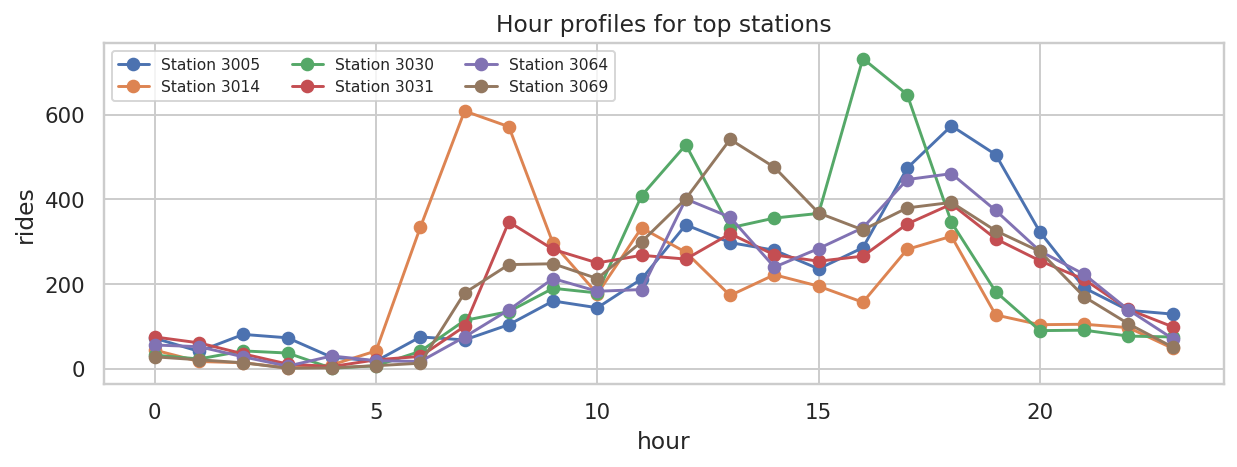

In [34]:
#Station Hour Profiles
top_ids = top_starts.head(6)["start_station_id"].tolist()
profiles = (df[df["start_station_id"].isin(top_ids)]
            .groupby(["start_station_id","hour"]).size()
            .rename("rides").reset_index())

plt.figure(figsize=(9,3.5))
for sid, g in profiles.groupby("start_station_id"):
    plt.plot(g["hour"], g["rides"], marker="o", label=f"Station {int(sid)}")
plt.title("Hour profiles for top stations")
plt.xlabel("hour"); plt.ylabel("rides"); plt.legend(ncol=3, fontsize=8)
plt.tight_layout(); plt.show()


In [35]:
summary = {}

In [36]:
# Time span
span = df["start_time"].max() - df["start_time"].min()
summary["time_span"] = f"{span} total span"


In [37]:
# Peaks
h_counts = df.groupby("hour").size()
summary["peak_hour"] = f"{int(h_counts.idxmax())}:00 ({int(h_counts.max()):,} rides)"

if n_days > 1:
    d_counts = df.groupby("dow").size()
    summary["peak_day"] = f"{d_counts.idxmax()} ({int(d_counts.max()):,} rides)"


In [38]:
# Top stations
top3 = top_starts.head(3)[["start_station_id","rides"]].values.tolist()
summary["top_stations"] = [f"Station {int(s)} — {int(n):,} rides" for s, n in top3]

In [39]:
# Typical trip stats
summary["median_distance_km"]  = round(float(df["trip_km"].median()), 2)
summary["median_duration_min"] = int(df["duration_min"].median())
summary["median_speed_kmh"]    = round(float(df["km_per_hr"].median()), 1)

pd.Series(summary)

time_span                                   267 days 19:28:00 total span
peak_hour                                           17:00 (11,654 rides)
peak_day                                         Thursday (20,191 rides)
top_stations           [Station 3069 — 5,091 rides, Station 3030 — 5,...
median_distance_km                                                  0.96
median_duration_min                                                   10
median_speed_kmh                                                     6.8
dtype: object

In [40]:
# Save tables for download in Kaggle
OUTPUT_DIR = Path("/kaggle/working")
if "heat" in globals():
    heat.to_csv(OUTPUT_DIR / "hour_by_day_heatmap_counts.csv")
top_starts.to_csv(OUTPUT_DIR / "top_origin_stations.csv", index=False)
flows.to_csv(OUTPUT_DIR / "top_flows.csv", index=False)

print("Saved files:")
print(" - /kaggle/working/station_hotspots.html")
print(" - /kaggle/working/top_flows_map.html (if created)")
print(" - /kaggle/working/hour_by_day_heatmap_counts.csv")
print(" - /kaggle/working/top_origin_stations.csv")
print(" - /kaggle/working/top_flows.csv")

Saved files:
 - /kaggle/working/station_hotspots.html
 - /kaggle/working/top_flows_map.html (if created)
 - /kaggle/working/hour_by_day_heatmap_counts.csv
 - /kaggle/working/top_origin_stations.csv
 - /kaggle/working/top_flows.csv
